# Conditional VAE

## Process

1. perform model-selection
    - without using CVAE_MODEL, perform hyperparamter grid-search
    - using the total-loss function
2. with the selected model, 
    - initilize the model in CVAE_MODEL
    - fit the model
    - save the model
3. compute DDloss
    - init CVAE_MODEL
    - load the model
    - generate patients
    - compute


In [1]:
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## CVAE

In [43]:
class CVAE(keras.Model):
    
    class Sampling(layers.Layer):
        """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

        def call(self, inputs):
            z_mean, z_log_var = inputs
            batch = tf.shape(z_mean)[0]
            dim = tf.shape(z_mean)[1]
            epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
            return z_mean + tf.exp(0.5 * z_log_var) * epsilon


    
    def __init__(self, latent_dim, input_shape, conditional_shape, **kwargs):
        
        super(CVAE, self).__init__(**kwargs)
        
        self.latent_dim = latent_dim
        self.nr_markers = input_shape - conditional_shape
        self.conditional_shape = conditional_shape
        
        self.encoder = self.create_encoder(latent_dim, input_shape)
        self.decoder = self.create_decoder(latent_dim, input_shape)
    
    
    def create_encoder(self, latent_dim, input_shape):
        """
        
        PARAMETERS
        ----------
        latent_dim: int
            the dimensision of latent variable
        input_shape: int
            the shape of the input data
            
        RETURNS
        -------
        encoder: keras model
            the encoder in the variational autoencoder.
        """
        # An encoder of single selfs.
        encoder_inputs = keras.Input(shape=(input_shape,), name="encoder_input")
        x = layers.Dense(10, activation="relu", name="encoder_l2")(encoder_inputs)
        x = layers.Dense(8, activation="relu",name="encoder_l3")(x)
        x = layers.Dense(6, activation="relu",name="encoder_l4")(x)

        z_mean = layers.Dense(latent_dim, name="z_mean")(x)
        z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
        
        z = CVAE.Sampling()([z_mean, z_log_var])

        encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
        return encoder
        
    def create_decoder(self, latent_dim, input_shape):
        """
        
        PARAMETERS
        ----------
        latent_dim: int
            the dimensision of latent variable
            
        RETURNS
        -------
        decoder: keras model
            the decoder in the variational autoencoder.
        """
        decoder_inputs = keras.Input(shape=(latent_dim+self.conditional_shape,), name ="latent_variable")
        x = layers.Dense(6, activation="relu", name="decoder_l2")(decoder_inputs)
        x = layers.Dense(8, activation="relu", name="decoder_l3")(x)
        x = layers.Dense(10, activation="relu",name="decoder_l4")(x)
        decoder_outputs = layers.Dense(input_shape, activation="relu", name="output_layer")(x)
        decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")
        return decoder


    
    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        
        with tf.GradientTape() as tape:
            
            condition = data[:, -self.conditional_shape:]
            
            z_mean, z_log_var, z = self.encoder(data)
            
            
            condititonal_z = keras.layers.concatenate([z, condition], axis=1)
            conditional_reconstruction = self.decoder(condititonal_z)
            
            # Use MSE as a construction loss, to be set as a parameter.
            mse = tf.keras.losses.MeanSquaredError()
            reconstruction_loss = mse(data, conditional_reconstruction)
            
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            
            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
    
    
    def call(self, inputs):
        _, _, encoded = self.encoder(inputs)
        e = keras.layers.concatenate([encoded, inputs[:,-2:]], axis=1)
        decoded = self.decoder(e)
        return decoded

        #reconst_images = decoder.predict(np.random.normal(0,1,size=(cell_per_patient, self.latent_dim)))

In [13]:
del CVAE

## DATA

In [6]:
cells = pd.read_csv("ModifiedDATA/scaled_ra.csv")

#### Add condition

In [ ]:
def add_id(df):
    cond = pd.get_dummies(df["group"]).astype("float32")

    data = df[df.columns.difference(["id","group"])]
    data = np.concatenate((data, cond), axis=1)
    
    return cond, data

cond, data = add_id(cells)
cond_shape = cond.shape[1]
data_shape = data.shape[1]

### CVAE - Model

In [10]:
# SELECTED HYPERPARAMETERS
LEARNING_RATE = 0.01
OPTIMIZER = keras.optimizers.Adam(LEARNING_RATE)
EPOCHS = 1
BATCH_SIZE = 128


LATENT_DIM = 2 


model = CVAE(LATENT_DIM, input_shape, group_id_shape)
#model.build((None,input_shape))

model.compile(optimizer=OPTIMIZER)

model.fit(data, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)

5000/5000 [==============================] - 6s 1ms/step - loss: 1.2068 - reconstruction_loss: 0.7761 - kl_loss: 0.4307 - val_loss: 0.0000e+00


In [11]:
filepath = "GenerativeModels/CVAE_1.tf"

In [12]:
# Save model
model.save(filepath)

INFO:tensorflow:Assets written to: GenerativeModels/CVAE_1.tf/assets


In [15]:
# Load Model
loaded_model = keras.models.load_model(filepath)#, custom_objects={"CVAE": CVAE}) 
#don't need the class for loading when using the default saveformat

In [33]:
generated_control = generate_patients(loaded_model, input_shape-group_id_shape, LATENT_DIM, group_id_shape, 20, 20, cells.columns.difference(["id","group"]), "control")
generated_diseased = generate_patients(loaded_model, input_shape-group_id_shape, LATENT_DIM, group_id_shape, 20, 20, cells.columns.difference(["id","group"]), "diseased")


In [34]:
generated = generated_control.append(generated_diseased)

## Hyperparameter search

In [2]:
# Hyperparameters
def rand_dec_layers(size, rang):
    s,e = rang
    sampled_list = random.sample(range(s,e),size)
    sampled_list.sort()
    return sampled_list
        
hyperparameters_encoder = {"nr_hidden_layers": list(range(2,12)),
                           "dim_per_layer" : lambda x : rand_dec_layers(x,(2,12)), 
                           "activation_function": ["relu","sigma", "sigmoid", "tanh", "selu", "softsign", "elu", "softmax"],
                          "reconstruction_loss": ["mse","mae","mape","msle", "logCos"]}
                            # optimizer
                            

## Final model for export

In [47]:
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

class CVAE_MODEL():
    
    def __init__(self):
        pass
    
    def convert_group(self, df):
        cond = pd.get_dummies(df["group"]).astype("float32")

        data = df[df.columns.difference(["id","group"])]
        data = np.concatenate((data, cond), axis=1)

        return cond, data

    def fit(self, data, latent_dim, epochs, batch_size, optimizer):
        
        # initilize the CVAE model
        cond, data = self.convert_group(data)
        cond_shape = cond.shape[1]
        data_shape = data.shape[1]
        
        self.model = CVAE(latent_dim, data_shape, cond_shape)
        
        # compile the model
        self.model.compile(optimizer=optimizer)
        
        # fit the model
        self.model.fit(data, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    
    def save(self, filepath):
        # save the model
        self.model.save(filepath)
    
    def load(self, filepath):
        # load the model
        # set self.model
        
        # TODO if filepath exists.
        self.model = keras.models.load_model(filepath)
        
        
        
    def generate_patients(self, nr_markers, latent_dim, conditional_dim, nr_cells = 20000, nr_patients = 20, column_names=None, group=None): 
        """
        PARAMETERS
        ----------
        nr_markers : int
        latent_dim : int
        conditional_dim : int
        nr_cells : int
        nr_patients : int
        column_names : Dataframe.columns
        group : str
            "control" or "diseased"
        
        RETURNS
        -------
        
        patients : dataframe
        
        """
        if self.model:
        
            patients = np.empty(shape=(nr_patients* nr_cells, nr_markers))
            p_id = np.empty(shape=nr_patients*nr_cells, dtype="int32")

            if group == "control":
                gr = np.concatenate((np.ones(shape=(nr_cells,1)),np.zeros(shape=(nr_cells,1))), axis=1)
            else:
                gr = np.concatenate((np.zeros(shape=(nr_cells,1)),np.ones(shape=(nr_cells,1))), axis=1)

            for i in range(nr_patients):
                # patient ids
                p_id[nr_cells*i : nr_cells*(i+1)] = np.full(shape=(nr_cells), fill_value=i+1, dtype="int32")

                sample = np.random.normal(0,1, size = (nr_cells, latent_dim))
                latent_vals = np.concatenate((sample, gr),axis=1)

                # sampled patient cells
                patients[nr_cells*i : nr_cells*(i+1)] = self.model.decoder.predict(latent_vals)[:,:-conditional_dim]

            patients_df = pd.DataFrame(patients, columns=column_names)


            patients_df["id"] = p_id
            patients_df["group"] = group

            return patients_df
        
    
    def embedd(self, X):
        """
        PARAMETERS:
        ----------
        X : dataframe or numpy array
        """
        # embedd data with the encoder
        
        return self.model.encoder.predict(X)
    
    def plot_embedding(self,data, labels=None):
        
        # display a 2D plot of the digit classes in the latent space
        _, _, z = self.model.encoder.predict(data)
        color = data[:,-group_id_shape:].argmax(axis=1)
        plt.figure(figsize=(12, 10))
        plt.scatter(z[:, 0], z[:, 1], label="Embedding")
        #plt.scatter(z_mean[:, 0], z_mean[:, 1], label="Means")
        #plt.scatter(z_var[:,0], z_var[:,1], label="Variance")
        #plt.colorbar()
        plt.legend()
        plt.xlabel("z_0")
        plt.ylabel("z_1")
        plt.show()

In [48]:
modeler = CVAE_MODEL()
modeler.fit(cells,LATENT_DIM, EPOCHS, BATCH_SIZE, OPTIMIZER)
filepath = "GenerativeModels/CVAE_1.tf"
modeler.save(filepath)
modeler.load(filepath)
#modeler.generate_patients()

5000/5000 [==============================] - 7s 1ms/step - loss: 1.4720 - reconstruction_loss: 1.4715 - kl_loss: 5.1036e-04 - val_loss: 0.0000e+00
INFO:tensorflow:Assets written to: GenerativeModels/CVAE_1.tf/assets


## Visualisation

In [35]:
# Add condition
gi = pd.get_dummies(generated["group"]).astype("float32")

d = generated[generated.columns.difference(["id","group"])]
d = np.concatenate((d, gi), axis=1)

In [36]:
def plot_label_clusters(encoder, decoder, data, labels=None):
    # display a 2D plot of the digit classes in the latent space
    _, _, z = encoder.predict(data)
    color = data[:,-group_id_shape:].argmax(axis=1)
    plt.figure(figsize=(12, 10))
    plt.scatter(z[:, 0], z[:, 1], label="Embedding")
    #plt.scatter(z_mean[:, 0], z_mean[:, 1], label="Means")
    #plt.scatter(z_var[:,0], z_var[:,1], label="Variance")
    #plt.colorbar()
    plt.legend()
    plt.xlabel("z_0")
    plt.ylabel("z_1")
    plt.show()

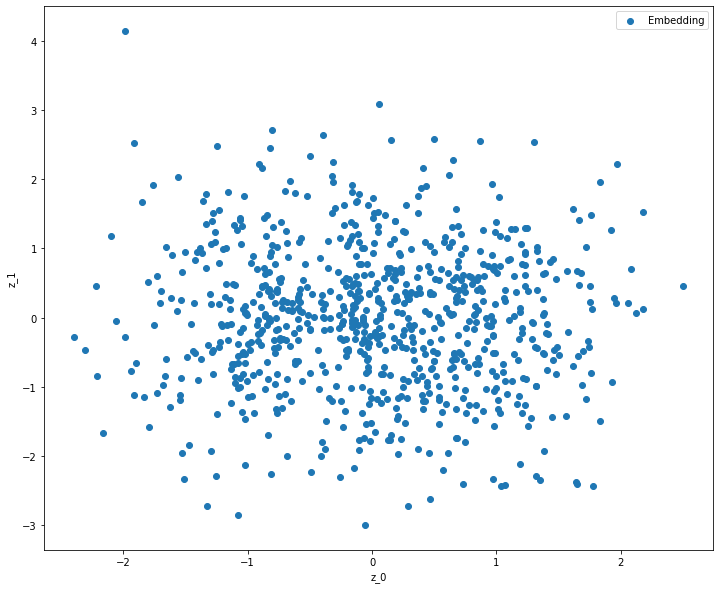

In [37]:
plot_label_clusters(loaded_model.encoder, loaded_model.decoder, d)

In [ ]:
class CGAN(keras.Model):
    
    def __init__(self, input_dim, latent_dim, optimizer = "adam", conditional_dim=None):
        super(CGAN, self).__init__()
        
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.conditional_dim = conditional_dim
        self.optimizer = optimizer
        
        self.generator = self.create_generator()
        self.discriminator = self.create_discrimenator()
        self.gan = self.create_gan()
        
    def create_generator(self):
         # generator of single events/cells
        generator_input = keras.Input(shape=(self.latent_dim,), name="latent_input")
        x = layers.Dense(10, activation="relu", name="generator_l1")(latent_input)
        x = layers.Dense(8, activation="relu",name="generator_l2")(x)
        x = layers.Dense(6, activation="relu",name="generator_l3")(x)
        generator_output = layers.Dense(self.input_dim, activation="relu", name = "generator")(x)
        g = keras.Model(generator_input, generator_output, name="generator")
        g.compile(optimizer = self.optimizer, loss = "binary_crossentropy")
        return g
    
    def create_discrimenator(self):
        # generator of single events/cells
        discriminator_input = keras.Input(shape=(self.input_dim,), name="latent_input")
        x = layers.Dense(10, activation="relu", name="generator_l1")(discriminator_input)
        x = layers.Dense(8, activation="relu",name="generator_l2")(x)
        x = layers.Dense(6, activation="relu",name="generator_l3")(x)
        discriminator_output = layers.Dense(1, activation="sigmoid", name = "generator")(x)
        d = keras.Model(discriminator_input, discriminator_output, name="generator")
        d.compile(optimizer = self.optimizer, loss = "binary_crossentropy")
        return d
    
    def create_gan(self):
        gan_input = keras.Input(shape=(self.input_dim), name="gan_input")
        x = self.generator(gan_input)
        gan_output = self.discriminator(x)
        gan = Model(inputs=gan_input, outputs=gan_output)
        gan.compile(loss='binary_crossentropy', optimizer = self.optimizer)
        
        return gan
    
    def generate_latent(self, shape):
        # currently random noice, consider using a some distribution?
        return np.random.normal(0,1, shape)
    
    def train_generator(self, data):
        # generate latent variable with the same number of items as data
        
        noice = self.generate_latent((self.latent_dim, data.shape[0]))

        X = self.generator(noice)
        # the desired target of the generated data is 
        # to be similar to the orginial data when it is judged by the discriminator.
        y = np.ones(data.shape[0]) 
        
        self.discriminator.trainable = False
        
        self.gan.train_on_batch(X, y)
        
    def train_discriminator(self, original_data):
        noice = self.generate_latent((self.latent_dim, original_data.shape[0])) # TODO
        generated_data = self.generator.predict(noice)
        
        X = np.concatenate([original_data, generated_data])
        
        self.discriminator.trainable = True
        
        y = np.zeros(2*original_data.shape[0])
        y [:original_data.shape[0]]= 1 # 1 = original data and 0 = generated data.
        
        self.gan.train_on_batch(X, y)
    
    def train_on_batch(self, x):
        self.train_discriminator(x)
        self.train_generator(x)